# Super Res Imagenet

In [1]:
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [3]:
from torchvision.models import vgg16_bn

In [4]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [7]:
assert path.exists(), f"need imagenet dataset @ {path}"
# create smaller image sets the first time this nb is run
sets = [(path_lr, 64), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [8]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8200: bs,size=16,256  
else:           bs,size=8,256
print(f"using bs={bs}, size={size}, have {free}MB of GPU RAM free")

arch = models.resnet34
# sample = 0.1
sample = False

tfms = get_transforms()

using bs=16, size=256, have 16188MB of GPU RAM free


In [9]:
src = ImageImageList.from_folder(path_lr)

In [10]:
if sample:
    src = src.filter_by_rand(sample, seed=42)

In [11]:
src = src.split_by_rand_pct(0.1, seed=42)

In [12]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    return data

In [13]:
data = get_data(bs, size)

## Feature Loss

### Gram Matrix

In [14]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2)) / (c * h * w)

In [15]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [21]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
feat_loss = FeatureLoss(vgg_m, blocks[2 : 5], [5, 15, 2])

In [18]:
blocks

[5, 12, 22, 32, 42]

## Training

In [19]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss,
                     callback_fns=LossMetrics, blur=True,
                     norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


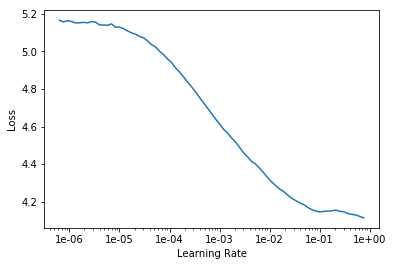

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 1e-3

In [26]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.560789,2.682446,0.216291,0.302608,0.345985,0.180290,0.472570,0.726049,0.438652,04:35
1,2.511588,2.651310,0.214498,0.301968,0.344922,0.179478,0.460614,0.713683,0.436146,04:32
2,2.516446,2.652457,0.223679,0.300135,0.340750,0.180027,0.458218,0.711286,0.438360,04:32
3,2.479103,2.644212,0.219208,0.298502,0.338774,0.179759,0.446104,0.724605,0.437261,04:32
4,2.450228,2.611847,0.217686,0.302080,0.335823,0.177508,0.446497,0.697618,0.434634,04:32
5,2.416533,2.533520,0.207938,0.295773,0.331667,0.175363,0.420321,0.669520,0.432936,04:32
6,2.411386,2.549929,0.216229,0.299453,0.332627,0.176755,0.423952,0.668332,0.432581,04:34
7,2.403902,2.504962,0.203124,0.291402,0.327444,0.174016,0.427205,0.654509,0.427261,04:35
8,2.393988,2.476665,0.202463,0.290754,0.325933,0.174848,0.406041,0.649771,0.426857,04:34
9,2.334741,2.423021,0.203211,0.291114,0.319266,0.172381,0.387509,0.630202,0.419338,04:35


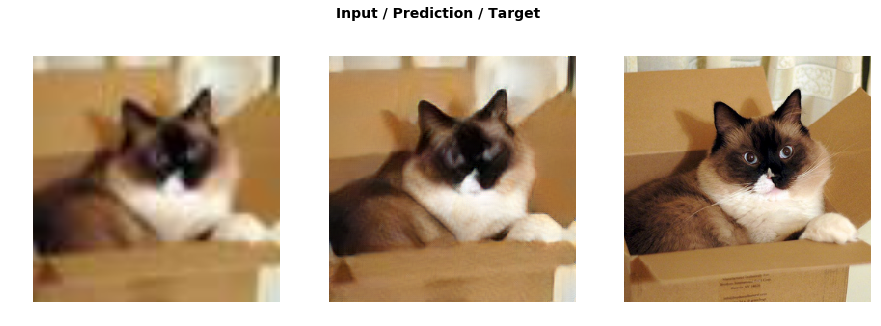

In [27]:
do_fit('1a', slice(lr * 10))